In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import sys

from sqlalchemy import false, true

# strongly recommand user to use Jupyter to test my model

# Q-Model class :  Calculate throughput time using formula

In [3]:
class QModel:
    def __init__(self, lam, miu , c):
        self.lam = lam
        self.miu = miu
        self.rho = lam/(c*miu)
        self.c = c
    
    def P0_MM1(self):
        return 1-self.rho
    
    def Pn_MM1(self, n):
        res = self.P0_MM1() * pow(self.rho,n)
        return res

    def Lq_MM1(self):
        return (pow(self.rho,2))/(1-self.rho)
    
    def Wq_MM1(self):
        res = self.Lq_MM1() / self.lam
        return res
    
    def Ws_MM1(self):
        res = self.Wq_MM1() + (1 / self.miu)
        return res
    
    def Ls_MM1(self):
        res = self.Ws_MM1() * self.lam 
        return res
    
    ### MMC 
    
    def P0_MMC(self):
        lam = self.lam
        miu = self.miu
        c = self.c
        res = 1.0
        for n in range(1,c):
            res += (pow((lam/miu),n)/math.factorial(n))
        
        res += (pow((lam/miu),c) / math.factorial(c)) * (1 / (1-(lam/(c*miu))))
        
        return 1 / res

    
    def Pn_MMC(self, n):
        lam = self.lam
        miu = self.miu
        c = self.c
        if n < c and n > 0:
            return ((pow((lam / miu), n)) / math.factorial(n)) * self.P0_MMC()
        return ((pow((lam / miu), n)) / (math.factorial(c) * pow(c, (n - c)))) * self.P0_MMC()

    
    def Lq_MMC(self):
        lam = self.lam
        miu = self.miu
        rho = self.rho
        c = self.c
        res =  (pow((lam/miu),c) * rho) / (math.factorial(c) * (pow(1-rho,2)))
        res = res * self.P0_MMC()
        return res
    
    def Wq_MMC(self):
        res = self.Lq_MMC() / self.lam
        return res
    
    def Ws_MMC(self):
        return self.Wq_MMC() + (1/self.miu)
    
    def Ls_MMC(self):
        return self.Lq_MMC() + (self.lam / self.miu)



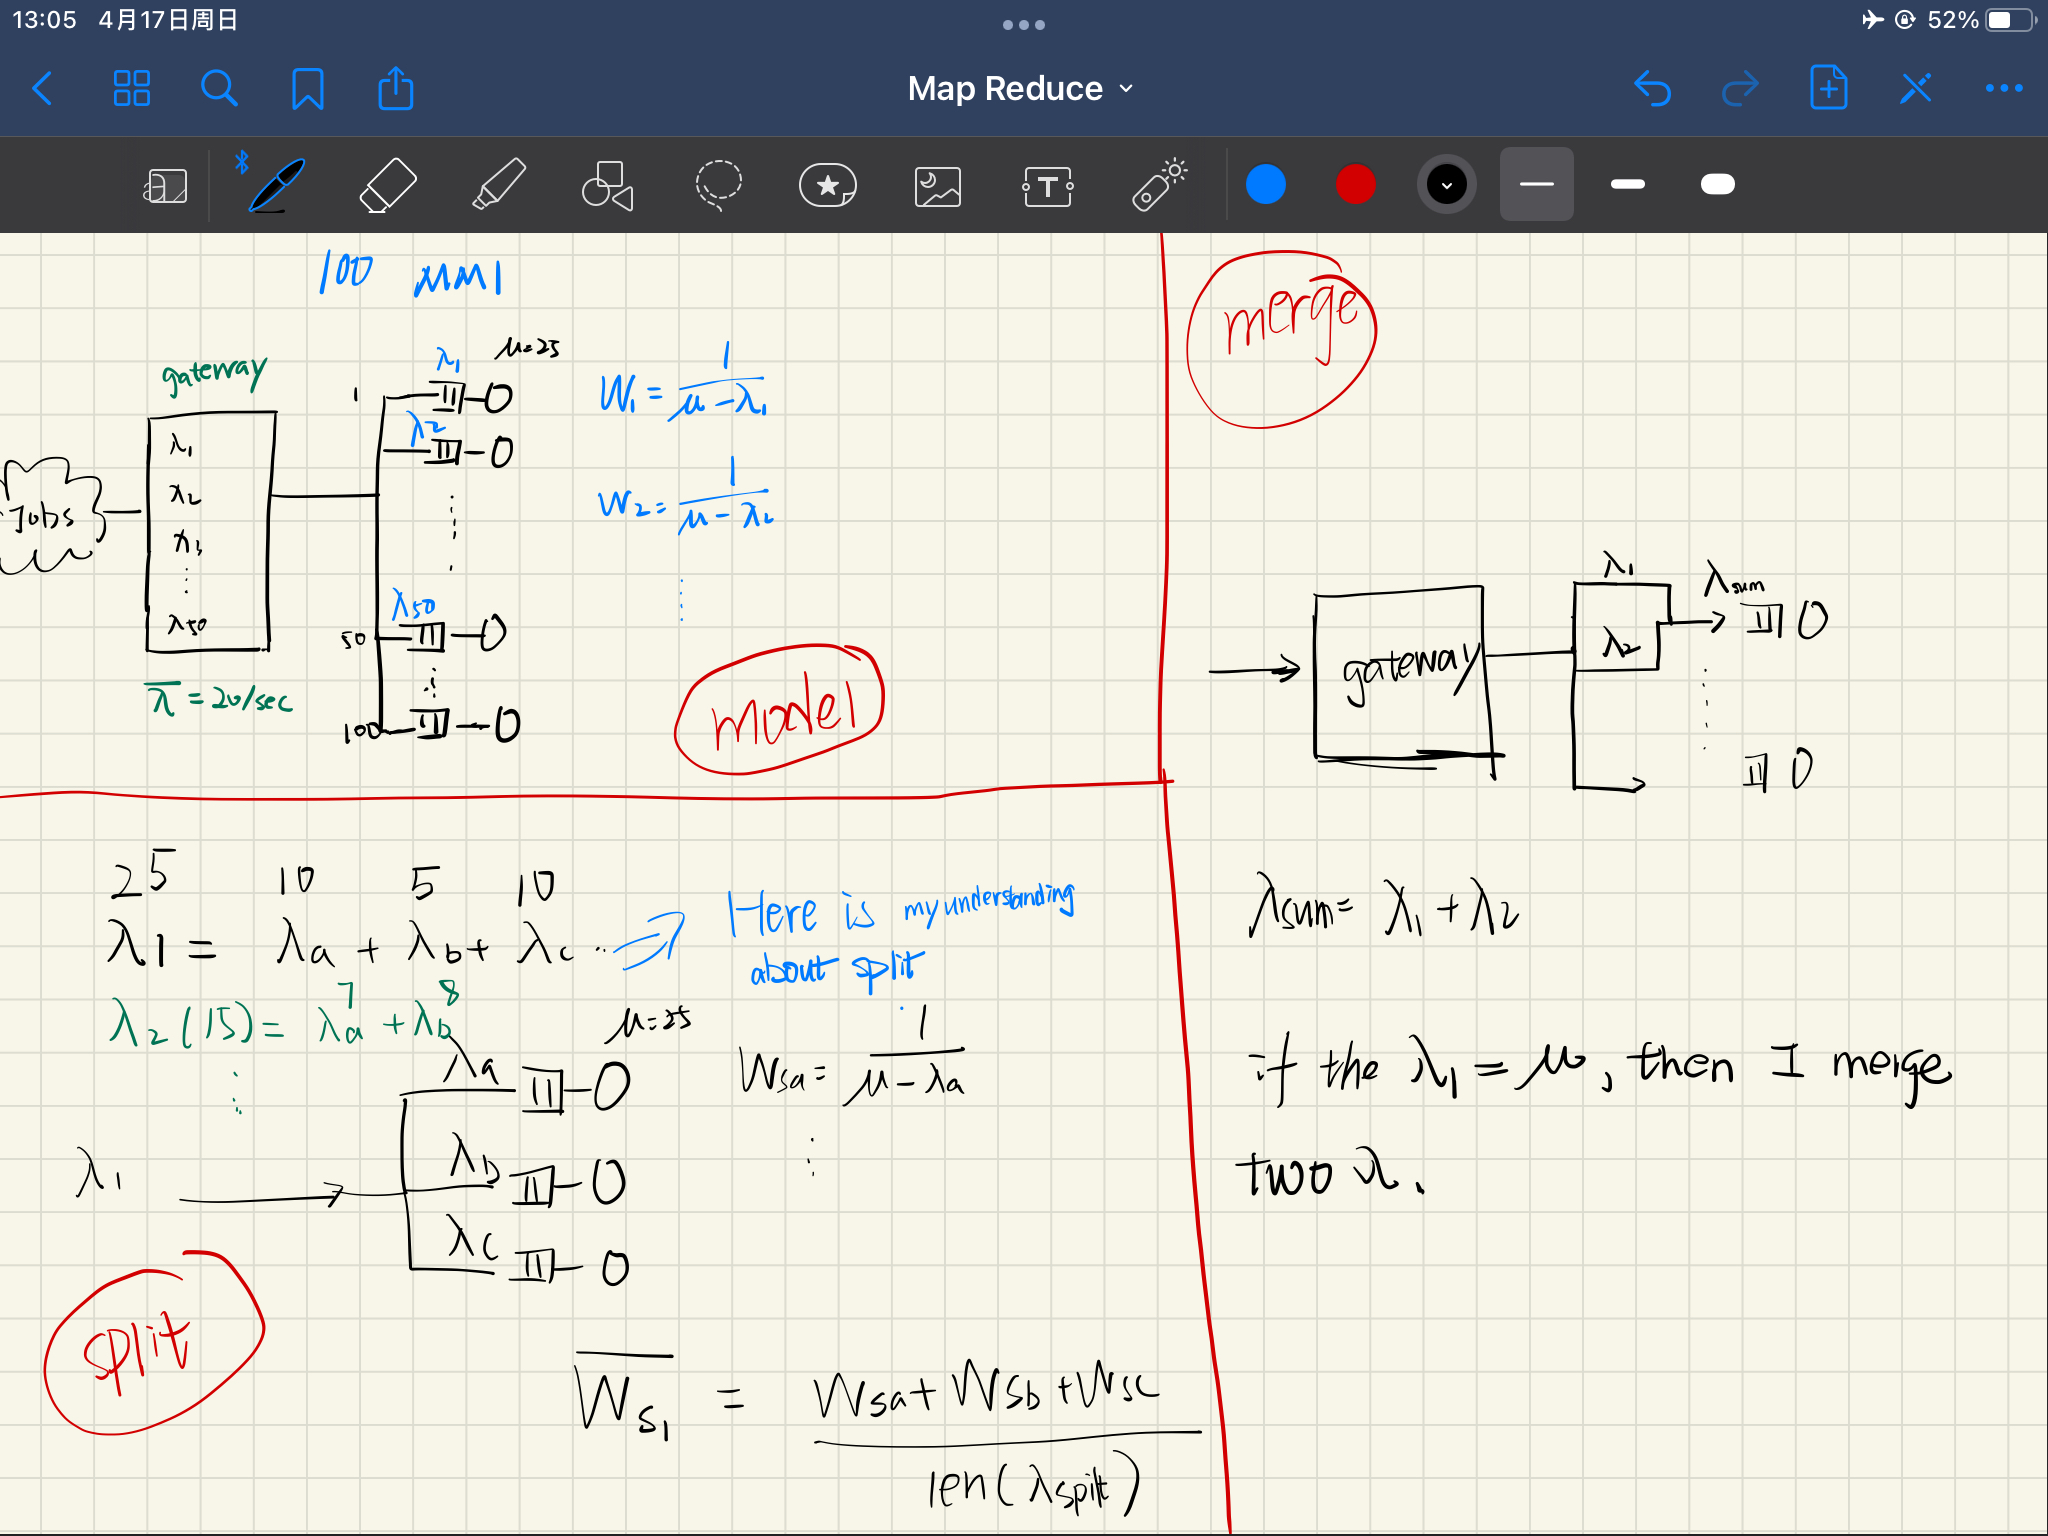


# JobFlow class mainly produces a set(50) of input flows with a mean value of 20
## Arriving jobs can be merged or segmented according to rules
#### 1） An input flow can be divided into several lambda, which are randomly determined, but the sum of each probability is 1
#### 2）More than one  input flows can be merged into one based on some limitation

In [46]:


# λ = Arrival Rate
# μ = Service Rate
# ρ = λ / μ
# C = Number of Service Channels
# M = Random Arrival/Service rate (Poisson)
# D = Deterministic Service Rate (Constant rate) 

#MM1 queue system


class JobFlow:
    def __init__(self, c, miu , numarr):
        self.c = c
        self.miu = miu
        self.numarr = numarr

    def SplitLam(self):
        count = np.random.randint(1,100)
        if (count == 1): return [1]
        pro_list = []
        for loop in range(0,count):
            pro_list.append(np.random.randint(1,10))
        pro_split = []
        sumAll = sum(pro_list)
        for i in pro_list:
            pro_split.append(i/sumAll)
        return pro_split


    def MergeMM1(self):
        c = self.c
        miu = self.miu
        numarr = self.numarr
        WsList = []
        sumJobs = 0
        for jobs in numarr:
            lam = jobs
            if jobs == miu:
                sumJobs += jobs
                continue
            else:
                if(sumJobs!=0):
                    queue = QModel(sumJobs,miu,c)
                    WsList.append(queue.Ws_MMC())
                    sumJobs = 0
                else :  
                    queue = QModel(lam,miu,c)
                    WsList.append(queue.Ws_MM1())
        return WsList
    
    def SplitMM1(self):
        WsList = []
        WsListfail = []
        c = self.c
        miu = self.miu
        numarr = self.numarr
        
        for jobs in numarr:
            lam = jobs
            pro_split = self.SplitLam()
            jobs = []
            con_Result = 0.0
            for pro in pro_split:
                num = pro * lam
                jobs.append(num)
            for c_pro in jobs:
                queue = QModel(c_pro,miu,c)
                con_Result += queue.Ws_MM1()
            WsList.append(con_Result/len(jobs))   
        return WsList


    def MM1Fail(self):
        WsListfail = []
        c = self.c
        miu = self.miu
        numarr = self.numarr
        fig, ax = plt.subplots(figsize=(8,4))
        failList = []
        for i in numarr:
            tmp = np.random.uniform(0.8,1)
            failList.append(1-tmp)
            
        failList.sort()
        i = 0
        numarr.sort()
        for jobs in numarr:
            lam = jobs
            pro_split = self.SplitLam()
            jobs = []
            con_Result = 0.0
            for pro in pro_split:
                num = pro * lam
                jobs.append(num)
            for c_pro in jobs:
                queue = QModel(c_pro,miu,c)
                con_Result += queue.Ws_MM1()
            
            
            failRate = 1-failList[i]
            failSum = con_Result / failRate
            WsListfail.append(failSum/len(jobs))   
            i = i+1
            
            
        WsListfail.sort()    
        np.savetxt("failRateVS_mean_throughput_time_MM1.txt", failList, delimiter=',',fmt='%s')   
        ax.plot(failList, WsListfail, color = 'r',  linewidth=1  , label = "Ws")
        ax.grid(True)
        ax.legend(loc='right')
        ax.set_title('Mean throughput time versus failure(MM1)')
        ax.set_xlabel('fail rate(%)')
        ax.set_ylabel('mean throughput time')
        filename6 = "Mean_throughput_time_versus_failure_MM1.png"
        plt.savefig(filename6,bbox_inches="tight")
        plt.show()

        return WsListfail

        
    def SplitMMC_MergeMMC(self,cate):
        WsList = []
        WsListfail = []
        c = self.c
        miu = self.miu
        numarr = self.numarr
        if cate == "split":
            for jobs in numarr:
                lam = jobs
                pro_split = self.SplitLam()
                jobs = []
                con_Result = 0.0
                for pro in pro_split:
                    num = pro * lam
                    jobs.append(num)
                for c_pro in jobs:
                    queue = QModel(c_pro,miu,c)
                    con_Result += queue.Ws_MMC()
                WsList.append(con_Result/len(jobs))
                
        elif cate == "merge":
            sumJobs = 0
            for jobs in numarr:
                lam = jobs
                if jobs == miu:
                    sumJobs += jobs
                    continue
                else:
                    if(sumJobs!=0):
                        queue = QModel(sumJobs,miu,c)
                        WsList.append(queue.Ws_MMC())
                        sumJobs = 0
                    else :  
                        queue = QModel(lam,miu,c)
                        WsList.append(queue.Ws_MMC())
        else:
            strF = []
            fig, ax = plt.subplots(figsize=(8,4))
            failList = []
            
            for i in numarr:
                tmp = np.random.uniform(0.8,1)
                failList.append(1-tmp)
            
            failList.sort()
            i = 0
            for jobs in numarr:
                lam = jobs
                pro_split = self.SplitLam()
                jobs = []
                con_Result = 0.0
                for pro in pro_split:
                    num = pro * lam
                    jobs.append(num)
                for c_pro in jobs:
                    queue = QModel(c_pro,miu,c)
                    con_Result += queue.Ws_MMC()
                    
                failRate = 1-failList[i]
                failSum = con_Result / failRate
                tmp = failSum/len(jobs)
                WsList.append(tmp) 
                i = i+1
                
            np.savetxt("failRateVS_mean_throughput_time_MMC.txt", failList, delimiter=',',fmt='%s')   
            ax.plot( failList, WsList, ls="-." , color = 'r',  linewidth=1  , label = "fail rate %")

            ax.grid(True)
            ax.legend(loc='right')
            ax.set_title('Mean throughput time versus failure(MMC)')
            ax.set_xlabel('fail rate(%)')
            ax.set_ylabel('mean throughput time')
            filename6 = "Mean_throughput_time_versus_failure_MMC.png"
            plt.savefig(filename6,bbox_inches="tight")
            plt.show()
        
        
        return WsList



# Q-Network class mainly produces a set(50) of input flows with a mean value of 20
### Process the information entered by the user, because the user doesn't need to input specific lambda and miu, the user can type number of selection(1 to 7)

# Program entry
### Each time a set of random lambda is generated, it will be stored in the file 
###  Options 5,6,7 all will plot a figure and relate data (format txt)
###  Options 5,6  Both options generate the relationship between failure rate and Ws. The failure rate is generated randomly, ranging from 0 to 20. Theoretically, the higher the failure rate, the higher the Ws

### Options7 : I cycled 20 times. In other words, I generated 50 input flows 20 times. It can be seen that the mean value of both models is about 0.05, but the performance of MMC model will be better



In [ ]:
class Qnetwork :
    def __init__(self, count, average , begin,end):
        self.count = count
        self.average = average
        self.begin = begin
        self.end = end
    
    def int_random (self):
        average = self.average
        begin  = self.begin
        end = self.end
        numarr = [0 for x in range(2)]
        i = 0
        while (1):
            num_first = random.randrange(begin, end)
            num_second = average * 2 - num_first
            if (num_second >= begin and num_second <= end):
                numarr[i] = num_first
                i = i + 1
                numarr[i] = num_second
                break
        return numarr

    def generateRate_Array(self):
        average = self.average
        begin  = self.begin
        end = self.end
        count = self.count
        numarr_count = 0
        numarr = [0 for x in range(count)]
        for i in range (int(count/2)):
            list = self.int_random ()
            j = 0
            for j in range (len(list)):
                numarr[numarr_count] = list[j]
                numarr_count += 1
        return numarr
    


Please enter the number 1 to 3 to select the test or enter 0 to exit the program
1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50
2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50
3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50
4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 50
5、Test MM1 model with  lambd1a = 20 , miu = 25 , n = 50 and fail rate within 20% (randomly)
6、Test MMC model with  lambda = 20 , miu = 20 , n = 50 and fail rate within 20% (randomly)
7、Compare the designs in terms of job mean throughput time
1
MM1 model(merge) : The mean value of 50 test sets is 
0.3275 
Please enter the number 1 to 3 to select the test or enter 0 to exit the program
1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50
2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50
3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50
4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 5

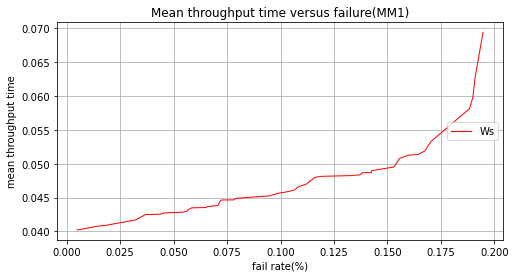

MM1 model with a failure rate of up to 20% : The mean value of 50 test sets is 
0.04695 
Please enter the number 1 to 3 to select the test or enter 0 to exit the program
1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50
2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50
3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50
4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 50
5、Test MM1 model with  lambd1a = 20 , miu = 25 , n = 50 and fail rate within 20% (randomly)
6、Test MMC model with  lambda = 20 , miu = 20 , n = 50 and fail rate within 20% (randomly)
7、Compare the designs in terms of job mean throughput time
6


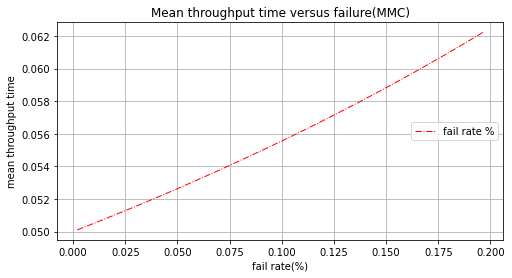

MMC model with a failure rate of up to 20% : The mean value of 50 test sets is 
0.05637 
Please enter the number 1 to 3 to select the test or enter 0 to exit the program
1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50
2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50
3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50
4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 50
5、Test MM1 model with  lambd1a = 20 , miu = 25 , n = 50 and fail rate within 20% (randomly)
6、Test MMC model with  lambda = 20 , miu = 20 , n = 50 and fail rate within 20% (randomly)
7、Compare the designs in terms of job mean throughput time
7


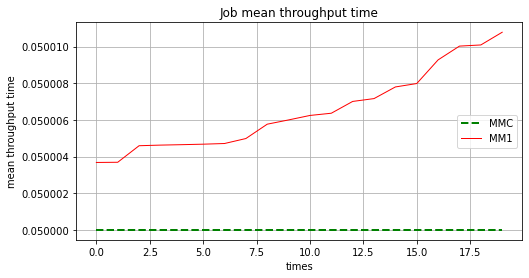

Please enter the number 1 to 3 to select the test or enter 0 to exit the program
1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50
2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50
3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50
4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 50
5、Test MM1 model with  lambd1a = 20 , miu = 25 , n = 50 and fail rate within 20% (randomly)
6、Test MMC model with  lambda = 20 , miu = 20 , n = 50 and fail rate within 20% (randomly)
7、Compare the designs in terms of job mean throughput time


In [ ]:


if __name__ == '__main__':
    # print("Input average arrival rate(lambda): ")
    # arrive_rate = int(input())
    # print("Input average service rate(miu) : ")
    # serve_rate = int(input())
    flag = true
    while(flag == true):
        print("Please enter the number 1 to 3 to select the test or enter 0 to exit the program")
        print("1、Test MM1 model(merge)  with  lambda = 20 , miu = 25 and n = 50")
        print("2、Test MM1 model(split) with  lambda = 20 , miu = 25 and n = 50")
        print("3、Test MMC model(merge) with c=20, lambda = 20 , miu = 20 and n = 50")
        print("4、Test MMC model(split) with c=20, lambda = 20 , miu = 20 and n = 50")
        print("5、Test MM1 model with  lambd1a = 20 , miu = 25 , n = 50 and fail rate within 20% (randomly)")
        print("6、Test MMC model with  lambda = 20 , miu = 20 , n = 50 and fail rate within 20% (randomly)")
        print("7、Compare the designs in terms of job mean throughput time")
    #     print("8、display above all")
        testNo = int(input())
        listTest = [1,2,3,4,5,6,7]
        while(testNo not in listTest):
            if testNo == 0:
                flag = false
                sys.exit() 
                                
        count = 50
        begin = 1
        average = 20
        numarr = []
        if(testNo == 1):
            lamList = Qnetwork(count, average, begin, 24)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(1,25,numarr)
            res = jobflow.MergeMM1()
            print("MM1 model(merge) : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))
        elif(testNo == 2):
            lamList = Qnetwork(count, average, begin, 50)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(1,25,numarr)
            res = jobflow.SplitMM1()
            print("MM1 model(split) : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))
        elif(testNo == 3):
            c =20
            lamList = Qnetwork(count, average, begin, 50)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(c,20,numarr)
            res = jobflow.SplitMMC_MergeMMC("merge")
            print("MMC model(merge) : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))
            
        elif(testNo == 4):
            c =20
            lamList = Qnetwork(count, average, begin, 50)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(c,20,numarr)
            res = jobflow.SplitMMC_MergeMMC("split")
            print("MMC model(split) : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))    
            
        elif(testNo == 5):
            lamList = Qnetwork(count, average, begin, 50)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(1,25,numarr)
            res = jobflow.MM1Fail()
            print("MM1 model with a failure rate of up to 20% : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))    
            
        elif(testNo == 6):
            c =20
            lamList = Qnetwork(count, average, begin, 50)
            numarr = lamList.generateRate_Array()
            jobflow = JobFlow(c,20,numarr)
            res = jobflow.SplitMMC_MergeMMC("fail")
            print("MMC model with a failure rate of up to 20% : The mean value of 50 test sets is ")
            print( '{:.4} '.format(sum(res)/len(res)))  
            
        elif(testNo == 7):       
            fig, ax = plt.subplots(figsize=(8,4))
            string = []
            y1 = []
            y2 = []
            for i in range(0,20):
                lamList = Qnetwork(count, average, begin, 50)
                numarr = lamList.generateRate_Array()
                jobflow = JobFlow(20,20,numarr)
                res = jobflow.SplitMMC_MergeMMC("split")
                res2 = jobflow.SplitMM1()
                string.append("MM1:"+str(sum(res2)/len(res2)) +"----- MMC"+str(sum(res)/len(res)) )
                y1.append(sum(res)/len(res))
                y2.append(sum(res2)/len(res2))     

            
            y1.sort()
            y2.sort()
            
            ax.plot( range(0,20) , y1,color = 'g',  ls='--', linewidth=2, label = "MMC")
            ax.plot( range(0,20), y2,color = 'r',  linewidth=1  , label = "MM1")
            ax.grid(True)
            ax.legend(loc='right')
            ax.set_title('Job mean throughput time')
            ax.set_xlabel('times')
            ax.set_ylabel('mean throughput time')
            filename7 = "Job_mean_throughput_time_MM1_MMC.png"
            plt.savefig(filename7,bbox_inches="tight")
            plt.show()
            filename2 = "Compare_mean_throughput_time_with_MM1_MMC_50.txt"
            np.savetxt(filename2, string, delimiter=',',fmt='%s')   
            
            
        np.savetxt("Generate_lambda_50.txt", numarr, delimiter=',',fmt='%s')   

            